# Inventory Monitoring at Distribution Centers
this notebook includes all steps that we need to use in this project for build and deploy a deep learning model for predict and classify Amazon Bin Images dataset. these image will be classified based on the number of items present in a bins.

the step following are:
- download amazon bin images dataset and upload it in S3 bucket
- train deep learning resnet50 model with our data
- train the model with hyperParameters
- deploy ans test the model 

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

In [1]:
# TODO: Install any packages that you might need
!pip install smdebug
!pip install ipywidgets

In [1]:
# TODO: Import any packages that you might need
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
import os
from sagemaker.serializers import IdentitySerializer
from PIL import Image
import io
import matplotlib.pyplot as plt
import IPython
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.session import TrainingInput

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [3]:
import os
import json
from tqdm import tqdm
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


100%|██████████| 1228/1228 [01:32<00:00, 13.32it/s]


100%|██████████| 2299/2299 [02:53<00:00, 13.22it/s]


100%|██████████| 2666/2666 [03:25<00:00, 12.98it/s]


100%|██████████| 2373/2373 [02:57<00:00, 13.35it/s]


100%|██████████| 1875/1875 [02:18<00:00, 13.54it/s]


## Dataset

Dataset used is amazon bin images, we download training data and arranges it in subfolders.Each of these subfolders contain images where the number of objects is equal to the name of the folder.
the dataset has 5 class, the images stored in subfolders from 1 to 5. for example :
- subfolder number 1 containts 1228 images with one object in bin.
- subfolder number 2 containts 2299 images with two objects in bin.
- subfolder number 3 containts 2666 images with 3 objects in bin.
- subfolder number 4 containts 2373 images with 4 objects in bin.
- subfolder number 5 containts 1875 images with 5 objects in bin.

You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

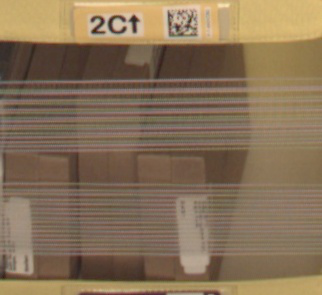

In [58]:
with open("train_data/4/00005.jpg", "rb") as f:
    payload = f.read()
    display(Image.open(io.BytesIO(payload)))

In [7]:
#TODO: Perform any data cleaning or data preprocessing
with open('file_list.json', 'r') as f:
    d=json.load(f)
data_v={}
for target, values in d.items():
    data_v[target]=len(d[target])
    print(f"the class {target} contains  {len(d[target])} images")
data_v

the class 1 contains  1228 images
the class 2 contains  2299 images
the class 3 contains  2666 images
the class 4 contains  2373 images
the class 5 contains  1875 images


{'1': 1228, '2': 2299, '3': 2666, '4': 2373, '5': 1875}

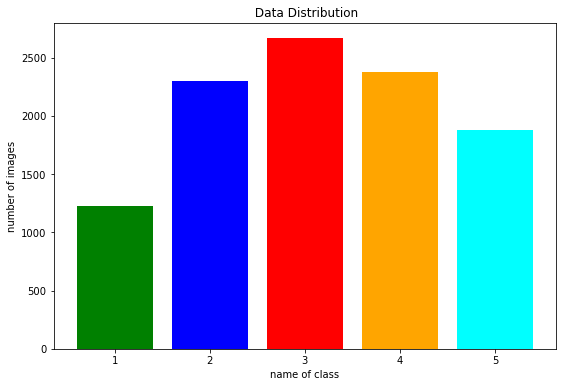

In [13]:
n_class = list(data_v.keys())
n_image = list(data_v.values())
bar_colors = ['green', 'blue', 'red', 'orange', 'cyan']

fig, ax = plt.subplots(figsize=(9, 6), sharey=True)
ax.bar(n_class, n_image, color=bar_colors)

ax.set_xlabel('name of class')
ax.set_ylabel('number of images')
ax.set_title(' Data Distribution')

plt.show()

In [4]:
#TODO: Upload the data to AWS S3
!aws s3 cp 'train_data' s3://capston-projects/data/ --recursive

upload: train_data/1/00024.jpg to s3://capston-projects/data/1/00024.jpg             
upload: train_data/1/00009.jpg to s3://capston-projects/data/1/00009.jpg             
upload: train_data/1/00035.jpg to s3://capston-projects/data/1/00035.jpg            
upload: train_data/1/00014.jpg to s3://capston-projects/data/1/00014.jpg            
upload: train_data/1/00152.jpg to s3://capston-projects/data/1/00152.jpg            
upload: train_data/1/00048.jpg to s3://capston-projects/data/1/00048.jpg            
upload: train_data/1/00084.jpg to s3://capston-projects/data/1/00084.jpg             
upload: train_data/1/00214.jpg to s3://capston-projects/data/1/00214.jpg             
upload: train_data/1/00088.jpg to s3://capston-projects/data/1/00088.jpg             
upload: train_data/1/00213.jpg to s3://capston-projects/data/1/00213.jpg             
upload: train_data/1/00148.jpg to s3://capston-projects/data/1/00148.jpg             
upload: train_data/1/00288.jpg to s3://capston-projects/da

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

In [14]:
#TODO: Declare your model training hyperparameter.
#NOTE: You do not need to do hyperparameter tuning. You can use fixed hyperparameter values
hyperparameters={'batch-size': 64,
                 'lr': 0.001,
                 "epochs": 3}
hyperparameters

{'batch-size': 64, 'lr': 0.001, 'epochs': 3}

In [3]:
output_path='s3://capston-projects/output/'
os.environ['SM_CHANNEL_TRAIN']='s3://capston-projects/data/'
os.environ['SM_MODEL_DIR']='s3://capston-projects/model/'
os.environ['SM_OUTPUT_DATA_DIR']=output_path

role = get_execution_role()
role

'arn:aws:iam::555855919726:role/service-role/AmazonSageMaker-ExecutionRole-20221214T101292'

In [22]:
#TODO: Create your training estimator
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    role=role,
    base_job_name = "bin-image-Cls",
    output_path= output_path,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
)

In [25]:
# TODO: Fit your estimator
model_inputs = {
    "train": f"s3://capston-projects/data/"
}
estimator.fit(model_inputs,wait=True)

2022-12-15 12:14:16 Starting - Starting the training job...
2022-12-15 12:14:42 Starting - Preparing the instances for trainingProfilerReport-1671106455: InProgress
......
2022-12-15 12:15:44 Downloading - Downloading input data......
2022-12-15 12:16:42 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-15 12:16:53,400 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-15 12:16:53,402 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-15 12:16:53,411 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-15 12:16:53,413 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-15 12:16:53,582 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-15 12:16:53,5

In [4]:
# TODO: Run an prediction on the endpoint
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    
    def __init__(self, endpoint_name, session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
model_location = "s3://capston-projects/output/bin-image-Cls-2022-12-15-12-14-15-721/output/model.tar.gz"
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

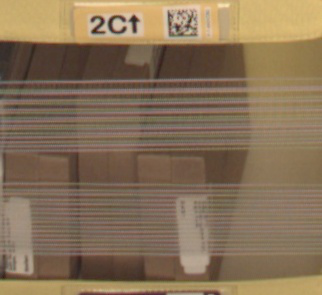

Response: [[-0.7648950219154358, -0.09488528966903687, 0.05409328266978264, 0.3153354227542877, -0.168979674577713]]


In [79]:
with open("train_data/4/00005.jpg", "rb") as f:
    payload2 = f.read()
    display(Image.open(io.BytesIO(payload2)))
    response2 = predictor.predict(payload2, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response2}")

In [80]:
class_= np.argmax(response2, 1)+1
print('class of the image is : ',class_)

class of the image is :  [4]


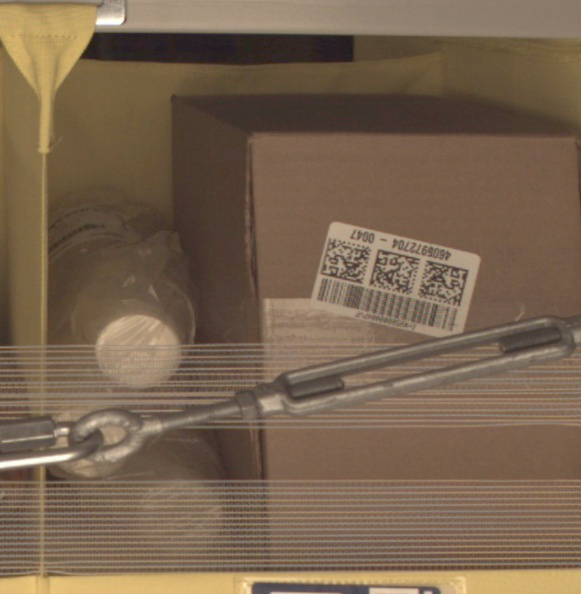

Response: [[-0.8075496554374695, 0.05586441233754158, 0.15758024156093597, 0.3542742133140564, -0.185348778963089]]
class of the image is :  [4]


In [12]:
with open("train_data/2/00777.jpg", "rb") as f:
    payload3 = f.read()
    display(Image.open(io.BytesIO(payload3)))
    response3 = predictor.predict(payload3, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response3}")
class_= np.argmax(response3, 1)+1
print('class of the image is : ',class_)

## Standout Suggestions
You do not need to perform the tasks below to finish your project. However, you can attempt these tasks to turn your project into a more advanced portfolio piece.

### Hyperparameter Tuning
**TODO:** Here you can perform hyperparameter tuning to increase the performance of your model. You are encouraged to 
- tune as many hyperparameters as you can to get the best performance from your model
- explain why you chose to tune those particular hyperparameters and the ranges.


In [27]:
#TODO: Create your hyperparameter search space
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32,64,128]),
    "epochs": IntegerParameter(2,6)
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [31]:
#TODO: Create your training estimator
output_path='s3://capston-projects/output/'
estimator =  PyTorch(
    entry_point="hpo.py",
    base_job_name="Image-bin-Hyper",
    role=role,
    output_path= output_path,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    framework_version="1.8",
    py_version="py36",
)

In [32]:
# TODO: Fit your estimator
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
)
tuner.fit(model_inputs,wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


### Describe the tuning results

In [34]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-221215-1327')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch-size,epochs,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,"""32""",2.0,0.033081,pytorch-training-221215-1327-001-0f4b9edc,Completed,1.587198,2022-12-15 13:29:24+00:00,2022-12-15 14:06:46+00:00,2242.0
0,"""32""",5.0,0.032418,pytorch-training-221215-1327-002-27ac0bc0,Completed,1.573572,2022-12-15 13:29:55+00:00,2022-12-15 14:06:53+00:00,2218.0


In [36]:
# TODO: Find the best hyperparameters
best_estimator = tuner.best_estimator()



2022-12-15 14:06:55 Starting - Preparing the instances for training
2022-12-15 14:06:55 Downloading - Downloading input data
2022-12-15 14:06:55 Training - Training image download completed. Training in progress.
2022-12-15 14:06:55 Uploading - Uploading generated training model
2022-12-15 14:06:55 Completed - Resource released due to keep alive period expiry


In [38]:
best_hpo = best_estimator.hyperparameters()
print("the best Hyper are : ")
best_hpo

the best Hyper are : 


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"32"',
 'epochs': '5',
 'lr': '0.03241780078105372',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Image-bin-Hyper-2022-12-15-13-27-44-955"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://capston-projects/Image-bin-Hyper-2022-12-15-13-27-44-955/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [39]:
# TODO: Set up debugging and profiling rules and hooks
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile,
    ProfilerRule,
    rule_configs,
)
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),    
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "5"},
    collection_configs = [CollectionConfig(name = "CrossEntropyLoss_output_0",
                                           parameters = {
                                               "include_regex": "CrossEntropyLoss_output_0",
                                               "train.save_interval": "10",
                                               "eval.save_interval": "1"})]
)

[2022-12-15 14:37:50.344 ip-172-16-99-186:8567 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [40]:
hyperparameters={'batch-size': 32,
                 'lr': 0.03241780078105372,
                 "epochs": 5}
hyperparameters

{'batch-size': 32, 'lr': 0.03241780078105372, 'epochs': 5}

In [41]:
model_inputs = {
    "train": f"s3://capston-projects/data/"
}

In [42]:
# TODO: Create and fit an estimator
output_path='s3://capston-projects/bestoutput/'

estimator = PyTorch(
    role=role,
    base_job_name = "bin-image-bestCls",
    output_path= output_path,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=hook_config,
    rules=rules,
)

estimator.fit(model_inputs,wait=True)

2022-12-15 14:45:13 Starting - Starting the training job...
2022-12-15 14:45:34 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2022-12-15 14:47:10 Downloading - Downloading input data...
2022-12-15 14:47:43 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-15 14:47:58,057 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-15 14:47:58,059 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-15 14:47:58,068 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-15 14:47:58,070 sagemaker_pytorch_container.training INFO   

In [43]:
# TODO: Plot a debugging output.

training_job_name = estimator.latest_training_job.name

print(f"Training jobname: {training_job_name}")

Training jobname: bin-image-bestCls-2022-12-15-14-45-12-913


In [44]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())


print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-12-15 15:49:51.468 ip-172-16-99-186:8567 INFO s3_trial.py:42] Loading trial debug-output at path s3://capston-projects/bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/debug-output


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[2022-12-15 15:49:51.895 ip-172-16-99-186:8567 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 235 more expected)', IncompleteRead(0 bytes read, 235 more expected)) while reading s3://capston-projects/bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/debug-output/index/000000000/000000000170_worker_0.json . Will retry now
[2022-12-15 15:49:56.317 ip-172-16-99-186:8567 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-12-15 15:49:57.343 ip-172-16-99-186:8567 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


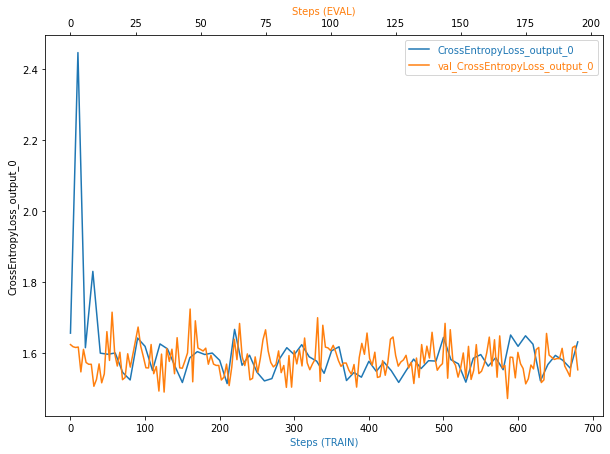

In [46]:
from mpl_toolkits.axes_grid1 import host_subplot
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [47]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f" profiler report  {rule_output_path}")

 profiler report  s3://capston-projects/bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/rule-output


In [48]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2022-12-15 15:45:07     386391 bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-12-15 15:45:07     236411 bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-12-15 15:45:02        192 bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-12-15 15:45:02        200 bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-12-15 15:45:02       2013 bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-12-15 15:45:02        127 bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-12-15 15:45:02        199 bestoutput/bin-image-be

In [49]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
profiler_report_name

'ProfilerReport'

In [50]:
# Display the profiler output
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [51]:
# TODO: Deploy your model to an endpoint
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.large")

------!

In [53]:
endpoint_name = predictor.endpoint_name
endpoint_name

'bin-image-bestCls-2022-12-15-16-12-11-257'

In [52]:
model_location=estimator.model_data
print(model_location)

s3://capston-projects/bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/output/model.tar.gz


In [55]:
session = boto3.session.Session()
session

Session(region_name='us-east-1')

In [57]:
# TODO: Run an prediction on the endpoint
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    
    def __init__(self, endpoint_name, session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
model_location = "s3://capston-projects/bestoutput/bin-image-bestCls-2022-12-15-14-45-12-913/output/model.tar.gz"
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce.py',py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

------!

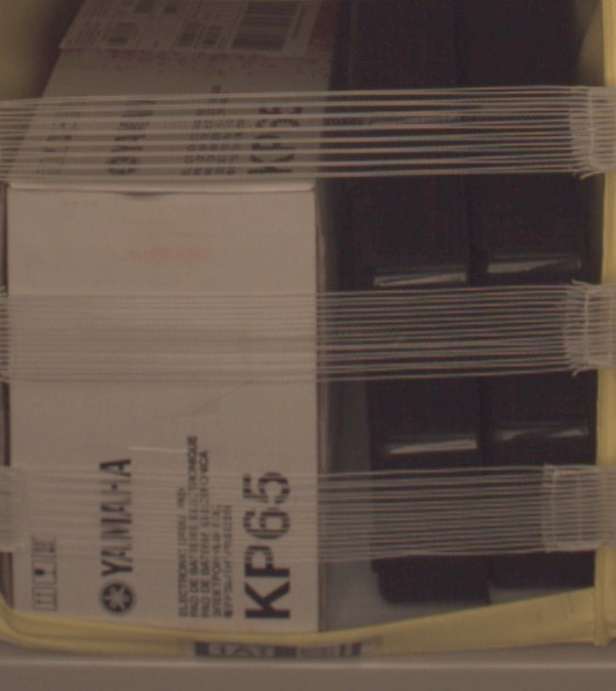

Response: [[-0.4381321668624878, 0.25044727325439453, 0.15298758447170258, 0.16632850468158722, -0.050031352788209915]]


In [62]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

with open("train_data/3/00153.jpg", "rb") as f:
    payload = f.read()
    display(Image.open(io.BytesIO(payload)))
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    print(f"Response: {response}")

In [63]:
import numpy as np
class_= np.argmax(response, 1)+1
print('class of the image is : ',class_)

class of the image is :  [2]


### Multi-Instance Training
train the model with 3 instances

In [8]:
hyperparameters={'batch-size': 64,
                 'lr': 0.001,
                 "epochs": 3}
hyperparameters

{'batch-size': 64, 'lr': 0.001, 'epochs': 3}

In [4]:
# TODO: Train your model on Multiple Instances
from sagemaker.pytorch import PyTorch
estimator = PyTorch(
    role=role,
    base_job_name = "bin-image-multi",
    output_path= output_path,
    instance_count=3,
    instance_type="ml.m5.xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
)

In [5]:
model_inputs = {
    "train": f"s3://capston-projects/data/"
}
estimator.fit(model_inputs,wait=True)

2022-12-16 09:59:14 Starting - Starting the training job...
2022-12-16 09:59:38 Starting - Preparing the instances for trainingProfilerReport-1671184753: InProgress
.........
2022-12-16 10:00:58 Downloading - Downloading input data...
2022-12-16 10:01:38 Training - Downloading the training image...
2022-12-16 10:01:58 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-16 10:01:59,852 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-16 10:01:59,854 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-16 10:01:59,863 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-16 10:01:59,865 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-16 10:02:00,027 sagemaker-training-toolkit INFO     No GP